# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=35,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 35)
OOV context shape: (16562, 28)
Right context shape: (16562, 35)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[-4.27615563e+36,  4.56767247e-41, -4.27615563e+36, ...,
         4.56767247e-41,  1.13221924e+27,  4.56767247e-41],
       [ 1.12124897e-40,  0.00000000e+00,  6.06875449e+26, ...,
         0.00000000e+00,  6.06889616e+26,  4.56767247e-41],
       [ 1.13227119e+27,  4.56767247e-41,  1.12140311e-40, ...,
         4.56767247e-41,  1.12154324e-40,  0.00000000e+00],
       ...,
       [ 1.13830165e+27,  4.56767247e-41,  1.13872316e-40, ...,
         4.56767247e-41,  1.13886329e-40,  0.00000000e+00],
       [ 8.39313574e+25,  4.56767247e-41,  1.13834887e+27, ...,
         4.56767247e-41,  1.13839610e+27,  4.56767247e-41],
       [ 1.13901743e-40,  0.00000000e+00,  8.39346040e+25, ...,
         0.00000000e+00,  8.39375555e+25,  4.56767247e-41]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=5.3852 | F1Score=0.2651
Batch-100: NLLLoss=4.5988 | F1Score=0.2913
Batch-150: NLLLoss=5.0409 | F1Score=0.3124
Batch-200: NLLLoss=4.3506 | F1Score=0.3384
Batch-250: NLLLoss=4.7303 | F1Score=0.3537
Batch-300: NLLLoss=4.3363 | F1Score=0.3742
Batch-350: NLLLoss=4.3102 | F1Score=0.3885
Batch-400: NLLLoss=2.8921 | F1Score=0.4041
Batch-450: NLLLoss=3.3365 | F1Score=0.4195
Batch-500: NLLLoss=4.1867 | F1Score=0.4324
Batch-518: NLLLoss=2.7669 | F1Score=0.4375

Mean NLLLoss: 4.4845 | Mean F1Score: 0.3494

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.6364 | F1Score=0.5875
Batch-100: NLLLoss=2.6804 | F1Score=0.5941
Batch-150: NLLLoss=2.5501 | F1Score=0.6008
Batch-200: NLLLoss=2.4848 | F1Score=0.6073
Batch-250: NLLLoss=1.6611 | F1Score=0.6176
Batch-300: NLLLoss=1.9355 | F1Score=0.6203
Batch-350: NLLLoss=2.2339 | F1Score=0.6240
Batch-400: NLLLoss=2.2928 | F1Score=0.6303
Batch-450: NLLLoss=2.6584 | F1Score=0.6385
Batch-500: NLLLoss=2.7978 | F1Score=0.6435
Batch-518: NLLLoss=2.1132 | F1Score=0.6443

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.6542 | Mean F1Score: 0.6158

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.1659 | F1Score=0.7312
Batch-100: NLLLoss=1.5896 | F1Score=0.7359
Batch-150: NLLLoss=1.1244 | F1Score=0.7347
Batch-200: NLLLoss=1.6654 | F1Score=0.7369
Batch-250: NLLLoss=1.9047 | F1Score=0.7352
Batch-300: NLLLoss=1.6596 | F1Score=0.7406
Batch-350: NLLLoss=0.9404 | F1Score=0.7429
Batch-400: NLLLoss=0.7670 | F1Score=0.7441
Batch-450: NLLLoss=1.7406 | F1Score=0.7446
Batch-500: NLLLoss=0.6242 | F1Score=0.7469
Batch-518: NLLLoss=2.5978 | F1Score=0.7479

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7744 | Mean F1Score: 0.7391

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.8688 | F1Score=0.8012
Batch-100: NLLLoss=1.3770 | F1Score=0.8043
Batch-150: NLLLoss=2.0271 | F1Score=0.8123
Batch-200: NLLLoss=0.8331 | F1Score=0.8120
Batch-250: NLLLoss=1.3462 | F1Score=0.8126
Batch-300: NLLLoss=1.1511 | F1Score=0.8127
Batch-350: NLLLoss=1.3272 | F1Score=0.8136
Batch-400: NLLLoss=1.4899 | F1Score=0.8141
Batch-450: NLLLoss=1.6573 | F1Score=0.8146
Batch-500: NLLLoss=1.7607 | F1Score=0.8146
Batch-518: NLLLoss=1.2251 | F1Score=0.8157

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1686 | Mean F1Score: 0.8102

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.8499 | F1Score=0.8934
Batch-100: NLLLoss=0.8156 | F1Score=0.8828
Batch-150: NLLLoss=0.7894 | F1Score=0.8823
Batch-200: NLLLoss=0.4655 | F1Score=0.8786
Batch-250: NLLLoss=0.4575 | F1Score=0.8789
Batch-300: NLLLoss=0.4797 | F1Score=0.8763
Batch-350: NLLLoss=1.0806 | F1Score=0.8746
Batch-400: NLLLoss=0.5188 | F1Score=0.8740
Batch-450: NLLLoss=0.6794 | F1Score=0.8728
Batch-500: NLLLoss=0.2769 | F1Score=0.8721
Batch-518: NLLLoss=0.1767 | F1Score=0.8725

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6968 | Mean F1Score: 0.8787

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.2475 | F1Score=0.9572
Batch-100: NLLLoss=0.2252 | F1Score=0.9548
Batch-150: NLLLoss=0.3794 | F1Score=0.9528
Batch-200: NLLLoss=0.3035 | F1Score=0.9518
Batch-250: NLLLoss=0.2862 | F1Score=0.9496
Batch-300: NLLLoss=0.3266 | F1Score=0.9465
Batch-350: NLLLoss=0.1859 | F1Score=0.9440
Batch-400: NLLLoss=0.1124 | F1Score=0.9423
Batch-450: NLLLoss=0.2220 | F1Score=0.9403
Batch-500: NLLLoss=0.5185 | F1Score=0.9379
Batch-518: NLLLoss=0.2628 | F1Score=0.9368

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3464 | Mean F1Score: 0.9488

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1222 | F1Score=0.9906
Batch-100: NLLLoss=0.0938 | F1Score=0.9900
Batch-150: NLLLoss=0.1024 | F1Score=0.9901
Batch-200: NLLLoss=0.1481 | F1Score=0.9899
Batch-250: NLLLoss=0.1014 | F1Score=0.9899
Batch-300: NLLLoss=0.0838 | F1Score=0.9898
Batch-350: NLLLoss=0.1345 | F1Score=0.9892
Batch-400: NLLLoss=0.0393 | F1Score=0.9888
Batch-450: NLLLoss=0.0655 | F1Score=0.9879
Batch-500: NLLLoss=0.1508 | F1Score=0.9873
Batch-518: NLLLoss=0.0197 | F1Score=0.9868

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1202 | Mean F1Score: 0.9898

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0148 | F1Score=0.9987
Batch-100: NLLLoss=0.0114 | F1Score=0.9975
Batch-150: NLLLoss=0.0181 | F1Score=0.9977
Batch-200: NLLLoss=0.0102 | F1Score=0.9981
Batch-250: NLLLoss=0.0159 | F1Score=0.9983
Batch-300: NLLLoss=0.0540 | F1Score=0.9980
Batch-350: NLLLoss=0.0252 | F1Score=0.9981
Batch-400: NLLLoss=0.0075 | F1Score=0.9979
Batch-450: NLLLoss=0.0342 | F1Score=0.9979
Batch-500: NLLLoss=0.0161 | F1Score=0.9981
Batch-518: NLLLoss=0.0095 | F1Score=0.9981

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0352 | Mean F1Score: 0.9979

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0099 | F1Score=0.9987
Batch-100: NLLLoss=0.0105 | F1Score=0.9994
Batch-150: NLLLoss=0.0047 | F1Score=0.9994
Batch-200: NLLLoss=0.0095 | F1Score=0.9992
Batch-250: NLLLoss=0.0150 | F1Score=0.9990
Batch-300: NLLLoss=0.0102 | F1Score=0.9990
Batch-350: NLLLoss=0.0093 | F1Score=0.9989
Batch-400: NLLLoss=0.0223 | F1Score=0.9990
Batch-450: NLLLoss=0.0144 | F1Score=0.9991
Batch-500: NLLLoss=0.0217 | F1Score=0.9991
Batch-518: NLLLoss=0.0202 | F1Score=0.9992

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0128 | Mean F1Score: 0.9991

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0065 | F1Score=0.9994
Batch-100: NLLLoss=0.0408 | F1Score=0.9991
Batch-150: NLLLoss=0.0031 | F1Score=0.9994
Batch-200: NLLLoss=0.0062 | F1Score=0.9994
Batch-250: NLLLoss=0.0054 | F1Score=0.9995
Batch-300: NLLLoss=0.0081 | F1Score=0.9994
Batch-350: NLLLoss=0.0066 | F1Score=0.9994
Batch-400: NLLLoss=0.0081 | F1Score=0.9995
Batch-450: NLLLoss=0.0062 | F1Score=0.9995
Batch-500: NLLLoss=0.0022 | F1Score=0.9995
Batch-518: NLLLoss=0.0026 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0077 | Mean F1Score: 0.9994

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0044 | F1Score=0.9991
Batch-100: NLLLoss=0.0038 | F1Score=0.9994
Batch-150: NLLLoss=0.0027 | F1Score=0.9996
Batch-200: NLLLoss=0.0036 | F1Score=0.9997
Batch-250: NLLLoss=0.0061 | F1Score=0.9997
Batch-300: NLLLoss=0.0020 | F1Score=0.9998
Batch-350: NLLLoss=0.0031 | F1Score=0.9998
Batch-400: NLLLoss=0.0037 | F1Score=0.9998
Batch-450: NLLLoss=0.0041 | F1Score=0.9999
Batch-500: NLLLoss=0.0029 | F1Score=0.9998
Batch-518: NLLLoss=0.0036 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0043 | Mean F1Score: 0.9997

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0044 | F1Score=1.0000
Batch-100: NLLLoss=0.0037 | F1Score=1.0000
Batch-150: NLLLoss=0.0039 | F1Score=1.0000
Batch-200: NLLLoss=0.0043 | F1Score=1.0000
Batch-250: NLLLoss=0.0032 | F1Score=0.9999
Batch-300: NLLLoss=0.0014 | F1Score=0.9999
Batch-350: NLLLoss=0.0046 | F1Score=0.9999
Batch-400: NLLLoss=0.0018 | F1Score=0.9999
Batch-450: NLLLoss=0.0021 | F1Score=0.9998
Batch-500: NLLLoss=0.0021 | F1Score=0.9998
Batch-518: NLLLoss=0.0031 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0032 | Mean F1Score: 0.9999

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0015 | F1Score=1.0000
Batch-100: NLLLoss=0.0026 | F1Score=1.0000
Batch-150: NLLLoss=0.0031 | F1Score=0.9999
Batch-200: NLLLoss=0.0032 | F1Score=0.9995
Batch-250: NLLLoss=0.5350 | F1Score=0.9941
Batch-300: NLLLoss=0.2287 | F1Score=0.9773
Batch-350: NLLLoss=0.5054 | F1Score=0.9635
Batch-400: NLLLoss=0.6437 | F1Score=0.9563
Batch-450: NLLLoss=0.3584 | F1Score=0.9522
Batch-500: NLLLoss=0.1354 | F1Score=0.9503
Batch-518: NLLLoss=0.0535 | F1Score=0.9502

Huft 😥! Model not improved.
Mean NLLLoss: 0.2123 | Mean F1Score: 0.9806
Patience = 1/20❗

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0551 | F1Score=0.9725
Batch-100: NLLLoss=0.0816 | F1Score=0.9756
Batch-150: NLLLoss=0.0799 | F1Score=0.9760
Batch-200: NLLLoss=0.0156 | F1Score=0.9765
Batch-250: NLLLoss=0.0826 | F1Score=0.9777
Batch-300: NLLLoss=0.0870 | F1Score=0.9792
Batch-350: NLLLoss=0.2121 | F1Score=0.9788
Batch-400: NLLLoss=0.0709 | F1Score=0.9795
Batch-450: NLLLoss=0.1431 | F1Score=0.9794
Batch-500: NLLLoss=0.0297 | F1Score=0.9797
Batch-518: NLLLoss=0.0150 | F1Score=0.9800

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0903 | Mean F1Score: 0.9771

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0101 | F1Score=0.9975
Batch-100: NLLLoss=0.0186 | F1Score=0.9980
Batch-150: NLLLoss=0.0014 | F1Score=0.9984
Batch-200: NLLLoss=0.0020 | F1Score=0.9988
Batch-250: NLLLoss=0.0133 | F1Score=0.9991
Batch-300: NLLLoss=0.0132 | F1Score=0.9991
Batch-350: NLLLoss=0.0253 | F1Score=0.9992
Batch-400: NLLLoss=0.0060 | F1Score=0.9992
Batch-450: NLLLoss=0.0103 | F1Score=0.9992
Batch-500: NLLLoss=0.0063 | F1Score=0.9992
Batch-518: NLLLoss=0.0015 | F1Score=0.9993

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0073 | Mean F1Score: 0.9986

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0021 | F1Score=1.0000
Batch-100: NLLLoss=0.0026 | F1Score=1.0000
Batch-150: NLLLoss=0.0019 | F1Score=1.0000
Batch-200: NLLLoss=0.0006 | F1Score=1.0000
Batch-250: NLLLoss=0.0023 | F1Score=1.0000
Batch-300: NLLLoss=0.0013 | F1Score=0.9999
Batch-350: NLLLoss=0.0016 | F1Score=1.0000
Batch-400: NLLLoss=0.0012 | F1Score=0.9999
Batch-450: NLLLoss=0.0011 | F1Score=0.9999
Batch-500: NLLLoss=0.0017 | F1Score=0.9999
Batch-518: NLLLoss=0.0015 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0017 | Mean F1Score: 1.0000

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0014 | F1Score=1.0000
Batch-100: NLLLoss=0.0013 | F1Score=1.0000
Batch-150: NLLLoss=0.0010 | F1Score=1.0000
Batch-200: NLLLoss=0.0014 | F1Score=1.0000
Batch-250: NLLLoss=0.0004 | F1Score=1.0000
Batch-300: NLLLoss=0.0007 | F1Score=0.9999
Batch-350: NLLLoss=0.0014 | F1Score=0.9999
Batch-400: NLLLoss=0.0015 | F1Score=0.9999
Batch-450: NLLLoss=0.0010 | F1Score=0.9999
Batch-500: NLLLoss=0.0009 | F1Score=0.9999
Batch-518: NLLLoss=0.0009 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0011 | Mean F1Score: 1.0000

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0009 | F1Score=1.0000
Batch-100: NLLLoss=0.0009 | F1Score=1.0000
Batch-150: NLLLoss=0.0008 | F1Score=0.9999
Batch-200: NLLLoss=0.0008 | F1Score=0.9999
Batch-250: NLLLoss=0.0005 | F1Score=0.9999
Batch-300: NLLLoss=0.0005 | F1Score=0.9999
Batch-350: NLLLoss=0.0008 | F1Score=1.0000
Batch-400: NLLLoss=0.0013 | F1Score=0.9999
Batch-450: NLLLoss=0.0015 | F1Score=0.9999
Batch-500: NLLLoss=0.0008 | F1Score=0.9999
Batch-518: NLLLoss=0.0009 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0009 | Mean F1Score: 0.9999

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0006 | F1Score=1.0000
Batch-100: NLLLoss=0.0008 | F1Score=0.9998
Batch-150: NLLLoss=0.0006 | F1Score=0.9999
Batch-200: NLLLoss=0.0008 | F1Score=0.9999
Batch-250: NLLLoss=0.0007 | F1Score=0.9999
Batch-300: NLLLoss=0.0009 | F1Score=0.9999
Batch-350: NLLLoss=0.0004 | F1Score=1.0000
Batch-400: NLLLoss=0.0009 | F1Score=1.0000
Batch-450: NLLLoss=0.0007 | F1Score=1.0000
Batch-500: NLLLoss=0.0009 | F1Score=0.9999
Batch-518: NLLLoss=0.0004 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0007 | Mean F1Score: 0.9999

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0005 | F1Score=1.0000
Batch-100: NLLLoss=0.0004 | F1Score=1.0000
Batch-150: NLLLoss=0.0004 | F1Score=1.0000
Batch-200: NLLLoss=0.0007 | F1Score=1.0000
Batch-250: NLLLoss=0.0006 | F1Score=0.9999
Batch-300: NLLLoss=0.0005 | F1Score=0.9999
Batch-350: NLLLoss=0.0007 | F1Score=0.9999
Batch-400: NLLLoss=0.0008 | F1Score=0.9999
Batch-450: NLLLoss=0.0006 | F1Score=0.9999
Batch-500: NLLLoss=0.0005 | F1Score=0.9999
Batch-518: NLLLoss=0.0005 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0006 | Mean F1Score: 1.0000

TRAINING SUMMARY
Best NLLLoss      : 0.0006
Best F1Score      : 1.0000
Training duration : 23.800 minutes.
Training date     : 2022-10-11 13:22:21.935699+08:00


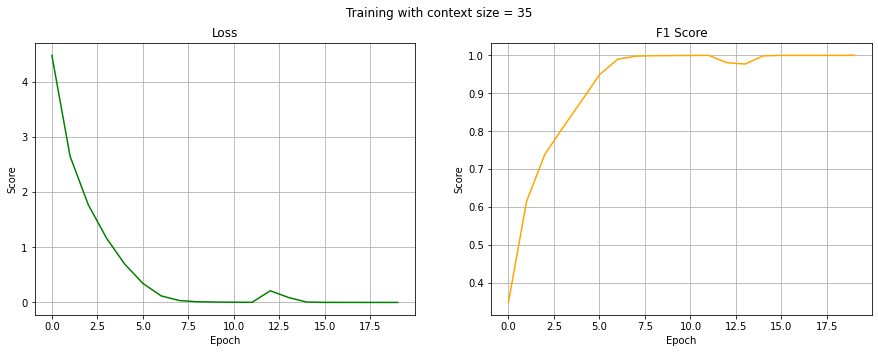

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[ 3.7789643e+00, -5.5841498e+00, -4.7837645e-01, ...,
         1.0964291e+00,  2.2574100e+00,  6.3730106e+00],
       [ 2.4053917e+00, -7.6676929e-01, -1.4827939e+00, ...,
         7.4372697e+00,  6.7552652e+00,  9.0681005e-01],
       [ 5.0565734e+00, -1.8809114e+00, -1.9765829e+00, ...,
         2.0403914e+00,  4.5391731e+00,  1.3514285e+00],
       ...,
       [-9.4184339e-01,  7.3819523e+00,  3.2114413e+00, ...,
         3.6277804e-01,  2.7269604e+00,  7.0721757e-01],
       [ 2.0267065e+00,  2.1025734e+00, -5.4531546e+00, ...,
         3.9958432e+00,  1.9528481e+00,  1.0125570e+00],
       [-6.7159539e-01, -6.9069564e-03, -3.4662941e+00, ...,
         7.1339822e+00, -1.0103465e+00,  4.9564385e+00]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[ 0.0086, -0.0383,  0.0861,  ..., -0.0211,  0.0184,  0.1249],
                      [-0.0108, -0.1992, -0.0025,  ..., -0.1677,  0.0347, -0.1086],
                      [ 0.3971, -0.2379,  0.0156,  ..., -0.0891,  0.0766,  0.0300],
                      ...,
                      [-0.0570, -0.1801,  0.1916,  ...,  0.0219, -0.0123, -0.3315],
                      [ 0.0650, -0.2584,  0.1362,  ...,  0.0029,  0.1288, -0.2022],
                      [-0.1104, -0.0572,  0.3117,  ...,  0.0069, -0.1813, -0.3331]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[-0.1176,  0.0571,  0.0379,  ...,  0.2007, -0.0447, -0.3122],
                      [ 0.0103, -0.3122,  0.0597,  ..., -0.0196,  0.0273,  0.2003],
                      [-0.3881,  0.0157, -0.0243,  ...,  0.1923,  0.0182,  0.0509],
                      ...,
                      [-0.2954, -0.4998,  0.1392,  ...,  0.0616,  0.250